<p style="color: white; font-size: 30px; text-align: center;"><b>Webscraping and Social Media Scraping</b></p>
<p style="color: white; font-size: 20px; text-align: center;">Project</p>
<p style="font-size: 20px; text-align: center;">Weronika Mądro, Wojciech Hrycenko</p>
<p style="font-size: 20px; text-align: center;">Spring 2025</p>

<p style="font-size: 20px; text-align: center;">1. Choice of the website and legal issues</p>

This project focuses on scraping data from Mediakrytyk (https://mediakrytyk.pl/), a platform aggregating moviesand series reviews from various sources. The platform assigns combined scores based on various sources, helping users make informed decisions about what to watch.

Web scraping should be conducted responsibly, adhering to legal and ethical guidelines. Before initiating the scraping process, we carefully reviewed Mediakrytyk’s terms of service to ensure compliance. This project respects the website's policies, making use of publicly available data while avoiding actions that could disrupt the platform's functionality.

Additionally, a standard practice when scraping is to check the website's robots.txt file, which provides guidelines on which parts of the site can be accessed by automated bots. Notably, Mediakrytyk does not have a robots.txt file, meaning there are no explicit crawling restrictions.

<p style="font-size: 20px; text-align: center;">2. Webscrapping process</p>

We scraped the TV series here using the BeautifulSoup library. 

1. In the first step we fetched the HTML from the ranking page while mimicking a real browser (User-Agent header). We pretended to be a real web browser by adding a special "User-Agent" header to our request. This trick makes the website think a human is visiting, so it sends us the full HTML content instead of blocking our scraper.

2. Later on, we parsed the page to extract details like title, original title, year, critic/user ratings, genre, country, duration and cover URL.

3. Finally, we stored the data in a pandas dataframe.


In [25]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
import time

# Configure Selenium (headless mode)
options = Options()
options.add_argument("--headless")
driver = webdriver.Chrome(executable_path=r"C:\\Users\\Weronika\\OneDrive\\Pulpit\\Data-Science\\Year 1 semester 2\\webscraping\\Webscrapping-Project\\chromedriver-win64\\chromedriver-win64")
driver = webdriver.Chrome(options=options)  # Ensure ChromeDriver is installed


# Load the page and wait for JavaScript
driver.get("https://mediakrytyk.pl/seriale/ranking")
time.sleep(3)  # Wait for lazy-loaded images

# Get the post-JavaScript HTML
soup = BeautifulSoup(driver.page_source, "html.parser")
driver.quit()  # Close the browser

# Extract images
for img in soup.select("img"):
    img_url = img.get("src") or img.get("data-src")
    if img_url and "empty_dark" not in img_url:  # Skip placeholders
        print(img_url)

ModuleNotFoundError: No module named 'selenium'

In [16]:
import requests
from bs4 import BeautifulSoup

url = "https://mediakrytyk.pl/seriale/ranking"
headers = {"User-Agent": "Mozilla/5.0"}

response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, "html.parser")

# Check for image tags
images = soup.find_all("img")
for img in images:
    print(img.get("src") or img.get("data-src") or img.get("data-lazy"))

/media/images/others_dark/logo.png
/media/images/empty_dark/movie.png
/media/images/empty_dark/movie.png
/media/images/empty_dark/movie.png
/media/images/empty_dark/movie.png
/media/images/empty_dark/movie.png
/media/images/empty_dark/movie.png
/media/images/empty_dark/movie.png
/media/images/empty_dark/movie.png
/media/images/empty_dark/movie.png
/media/images/empty_dark/movie.png
/media/images/empty_dark/movie.png
/media/images/empty_dark/movie.png
/media/images/empty_dark/movie.png
/media/images/empty_dark/movie.png
/media/images/empty_dark/movie.png
/media/images/empty_dark/movie.png
/media/images/empty_dark/movie.png
/media/images/empty_dark/movie.png
/media/images/empty_dark/movie.png
/media/images/empty_dark/movie.png
/media/images/empty_dark/movie.png
/media/images/empty_dark/movie.png
/media/images/empty_dark/movie.png
/media/images/empty_dark/movie.png
/media/images/empty_dark/movie.png
/media/images/empty_dark/movie.png
/media/images/empty_dark/movie.png
/media/images/empty_

1
https://mediakrytyk.pl/media/images/empty_dark/movie.png



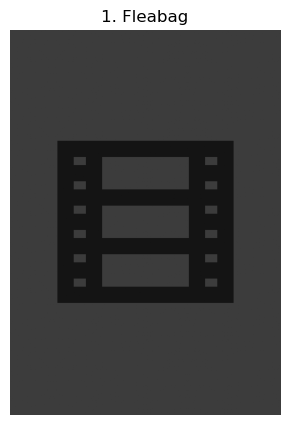

2
https://mediakrytyk.pl/media/images/empty_dark/movie.png



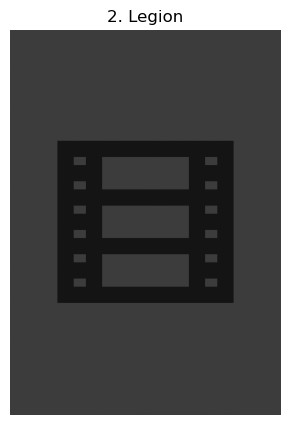

3
https://mediakrytyk.pl/media/images/empty_dark/movie.png



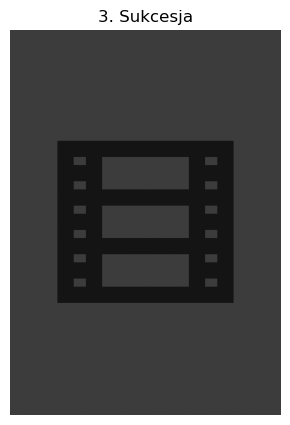

4
https://mediakrytyk.pl/media/images/empty_dark/movie.png



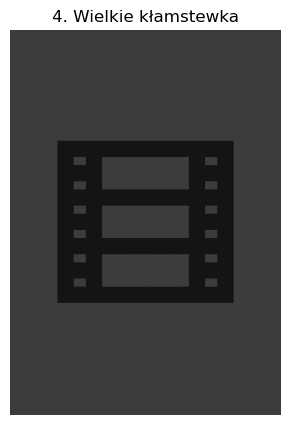

5
https://mediakrytyk.pl/media/images/empty_dark/movie.png



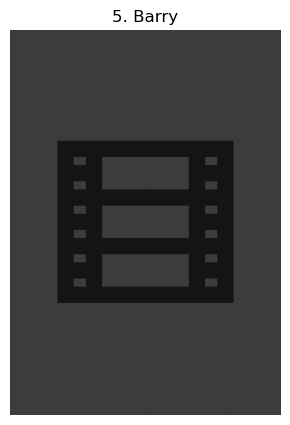

6
https://mediakrytyk.pl/media/images/empty_dark/movie.png



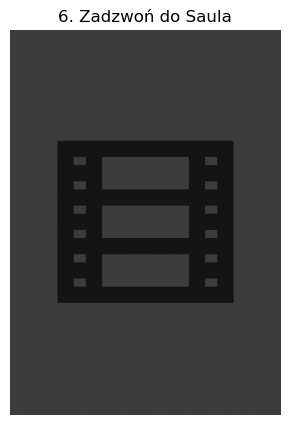

7
https://mediakrytyk.pl/media/images/empty_dark/movie.png



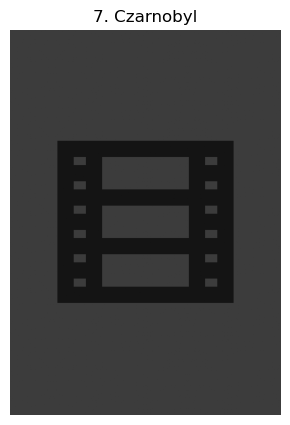

8
https://mediakrytyk.pl/media/images/empty_dark/movie.png



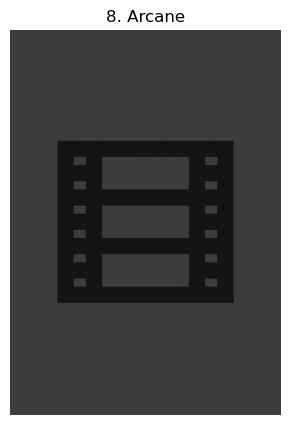

9
https://mediakrytyk.pl/media/images/empty_dark/movie.png



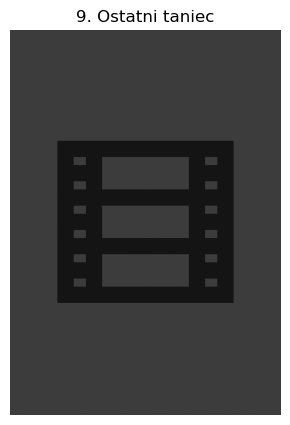

10
https://mediakrytyk.pl/media/images/empty_dark/movie.png



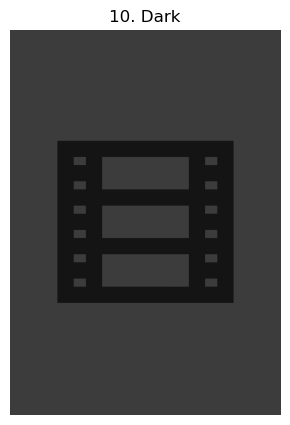

11
https://mediakrytyk.pl/media/images/empty_dark/movie.png



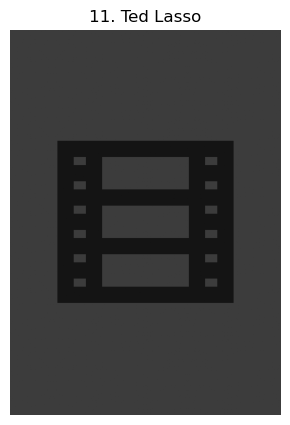

12
https://mediakrytyk.pl/media/images/empty_dark/movie.png



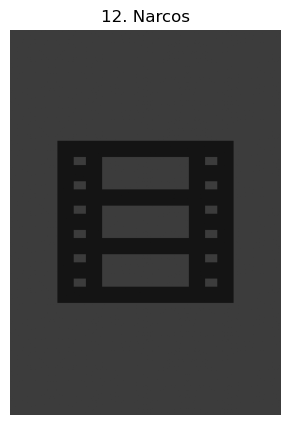

13
https://mediakrytyk.pl/media/images/empty_dark/movie.png



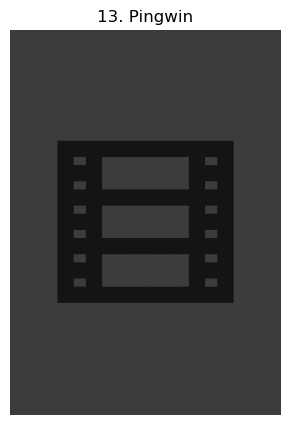

14
https://mediakrytyk.pl/media/images/empty_dark/movie.png



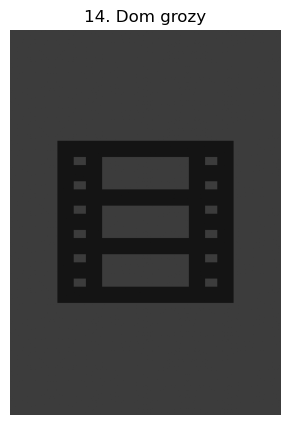

15
https://mediakrytyk.pl/media/images/empty_dark/movie.png



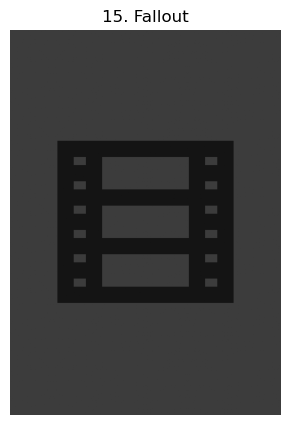

16
https://mediakrytyk.pl/media/images/empty_dark/movie.png



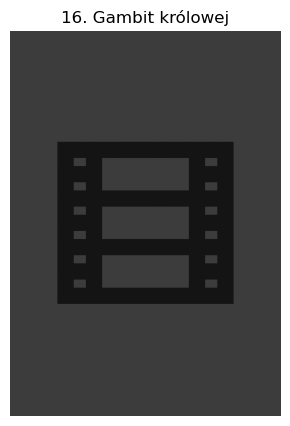

17
https://mediakrytyk.pl/media/images/empty_dark/movie.png



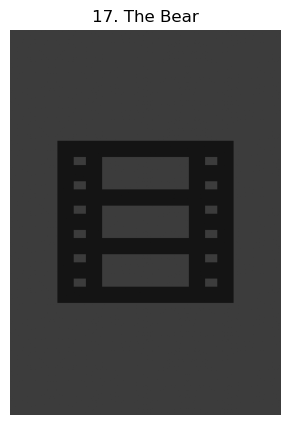

18
https://mediakrytyk.pl/media/images/empty_dark/movie.png



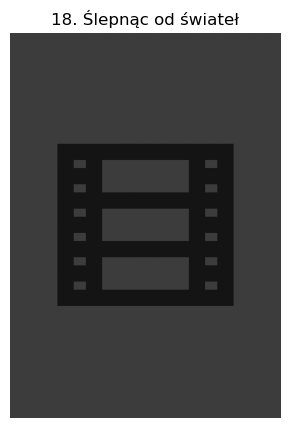

19
https://mediakrytyk.pl/media/images/empty_dark/movie.png



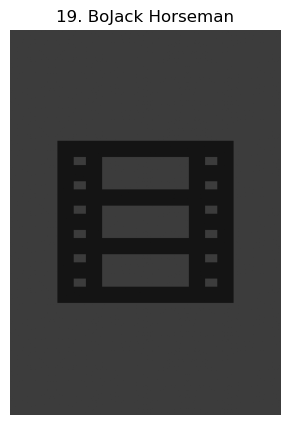

20
https://mediakrytyk.pl/media/images/empty_dark/movie.png



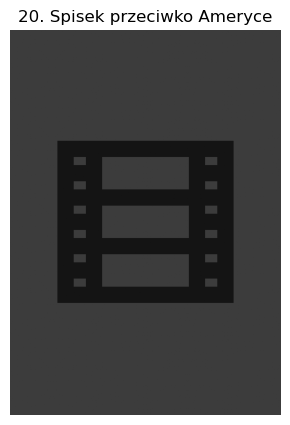

21
https://mediakrytyk.pl/media/images/empty_dark/movie.png



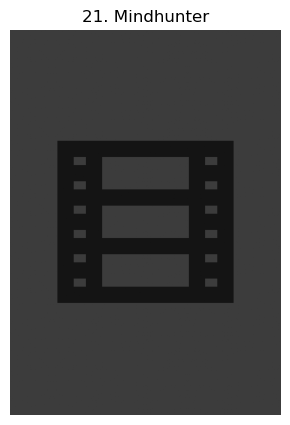

22
https://mediakrytyk.pl/media/images/empty_dark/movie.png



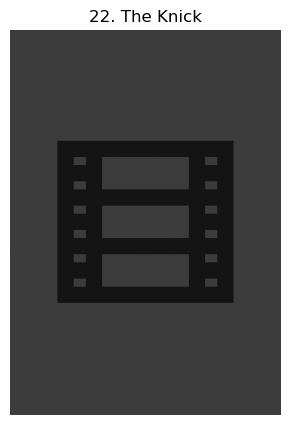

23
https://mediakrytyk.pl/media/images/empty_dark/movie.png



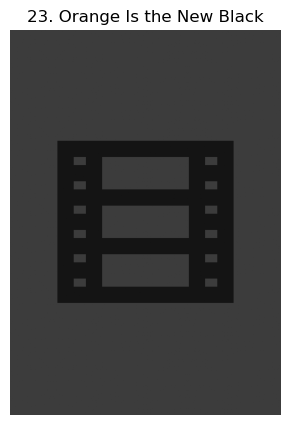

24
https://mediakrytyk.pl/media/images/empty_dark/movie.png



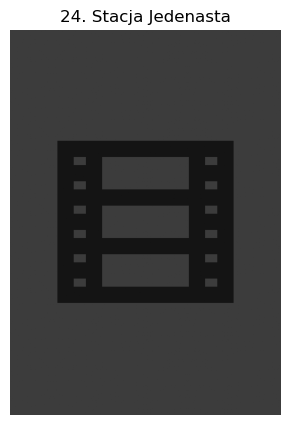

25
https://mediakrytyk.pl/media/images/empty_dark/movie.png



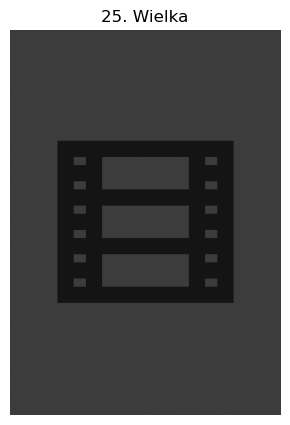

26
https://mediakrytyk.pl/media/images/empty_dark/movie.png



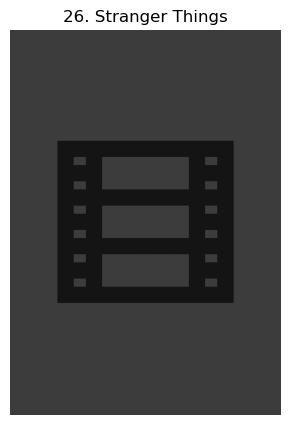

27
https://mediakrytyk.pl/media/images/empty_dark/movie.png



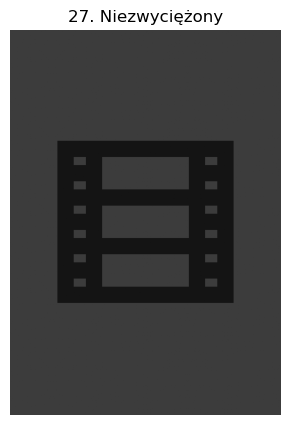

28
https://mediakrytyk.pl/media/images/empty_dark/movie.png



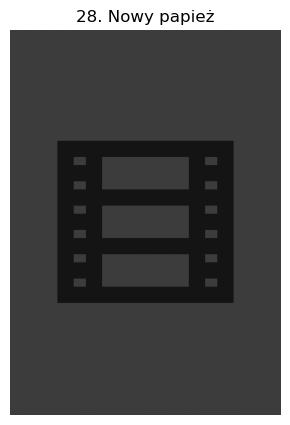

29
https://mediakrytyk.pl/media/images/empty_dark/movie.png



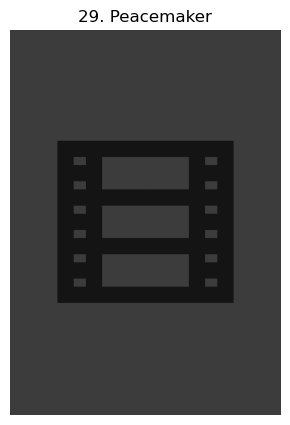

30
https://mediakrytyk.pl/media/images/empty_dark/movie.png



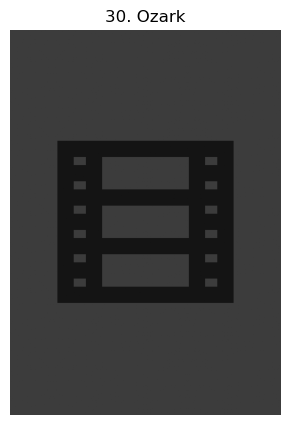

31
https://mediakrytyk.pl/media/images/empty_dark/movie.png



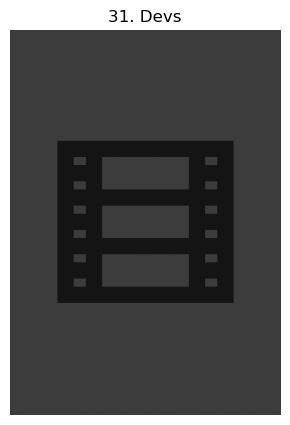

32
https://mediakrytyk.pl/media/images/empty_dark/movie.png



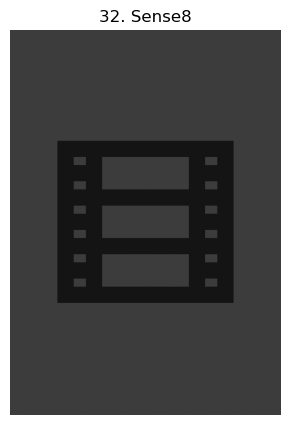

33
https://mediakrytyk.pl/media/images/empty_dark/movie.png



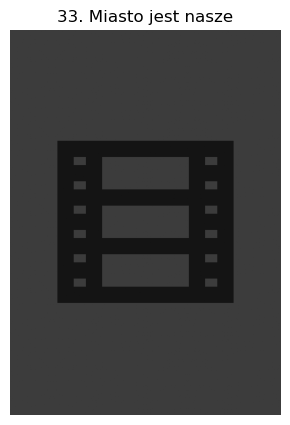

34
https://mediakrytyk.pl/media/images/empty_dark/movie.png



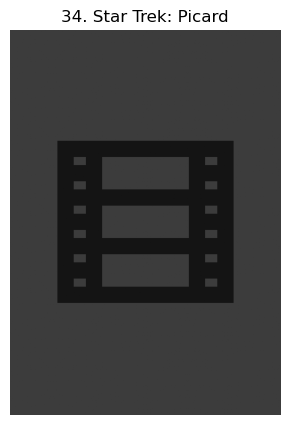

35
https://mediakrytyk.pl/media/images/empty_dark/movie.png



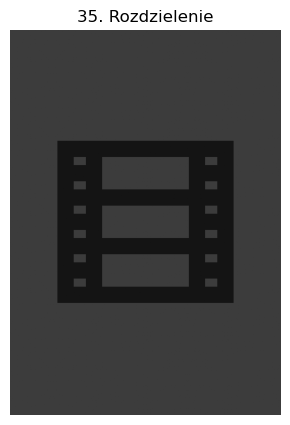

36
https://mediakrytyk.pl/media/images/empty_dark/movie.png



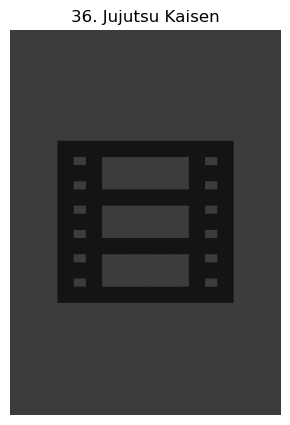

37
https://mediakrytyk.pl/media/images/empty_dark/movie.png



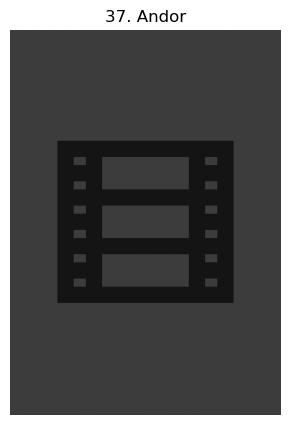

38
https://mediakrytyk.pl/media/images/empty_dark/movie.png



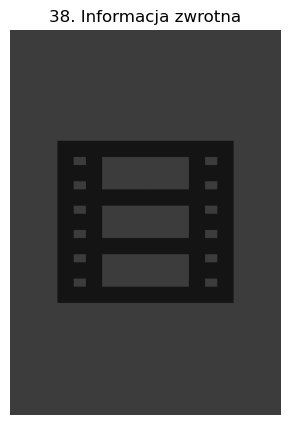

39
https://mediakrytyk.pl/media/images/empty_dark/movie.png



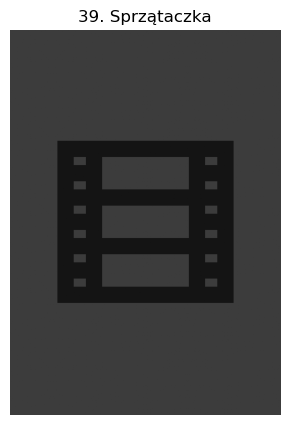

40
https://mediakrytyk.pl/media/images/empty_dark/movie.png



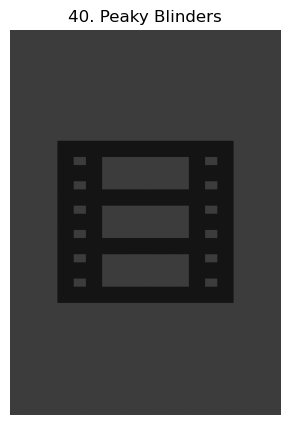

41
https://mediakrytyk.pl/media/images/empty_dark/movie.png



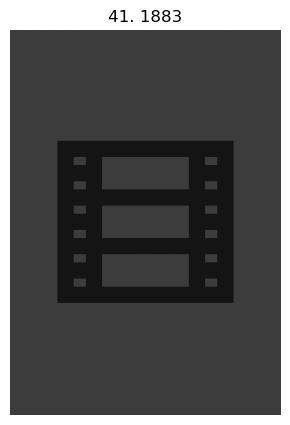

42
https://mediakrytyk.pl/media/images/empty_dark/movie.png



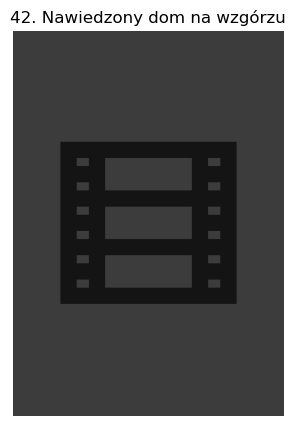

In [14]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import shutil
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Create directory for images if it doesn't exist
if not os.path.exists('series_covers'):
    os.makedirs('series_covers')

def scrape_and_download_covers():
    url = "https://mediakrytyk.pl/seriale/ranking"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"}
    
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Error: {response.status_code}")
        return []
    
    soup = BeautifulSoup(response.text, "html.parser")
    series_data = []
    
    for index, item in enumerate(soup.select("ul > li > div > div:nth-of-type(3) > div > div:nth-of-type(1) > h3 > a"), start=1):
        title = item.text.strip()
        parent = item.find_parent("li")
        
        # Extract cover image URL
        cover_element = parent.select_one("div > div:nth-of-type(2) > a > img.movie_full_image")
        if cover_element and 'src' in cover_element.attrs:
            cover_url = "https://mediakrytyk.pl" + cover_element["src"]
            
            # Download and save the image
            img_response = requests.get(cover_url, stream=True, headers=headers)
            if img_response.status_code == 200:
                filename = f"series_covers/{index}_{title.replace('/', '_')}.jpg"
                with open(filename, 'wb') as f:
                    img_response.raw.decode_content = True
                    shutil.copyfileobj(img_response.raw, f)
                
                # Print the ranking number and image URL
                print(f"{index}\n{cover_url}\n")
                
                # Display the image
                img = mpimg.imread(filename)
                plt.figure(figsize=(5, 5))
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"{index}. {title}")
                plt.show()
            
            series_data.append({
                "Rank": index,
                "Title": title,
                "Cover URL": cover_url
            })
    
    return pd.DataFrame(series_data)

# Run the function
df = scrape_and_download_covers()

In [13]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Function to scrape movie list from Mediakrytyk ranking
def scrape_mediakrytyk_movies():
    url = "https://mediakrytyk.pl/seriale/ranking"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"}
    
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Error: {response.status_code}")
        return []
    
    soup = BeautifulSoup(response.text, "html.parser")
    movies = []
    
    for index, item in enumerate(soup.select("ul > li > div > div:nth-of-type(3) > div > div:nth-of-type(1) > h3 > a"), start=1):
        title = item.text.strip()
        parent = item.find_parent("li")  # Get the main movie container
        
        # Extract year
        year_element = parent.select_one("a.label_small.link")
        year = year_element.text.strip() if year_element else "No year"
        
        # Extract critic rating
        critic_rating_element = parent.select_one("a.movie_full_vscore_symbol.score_symbol.link.background.small.level_1.small_hide")
        critic_rating = critic_rating_element.text.strip() if critic_rating_element else "No critic rating"
        
        # Extract user rating
        user_rating_element = parent.select_one("a.movie_full_vuscore_symbol.score_symbol.link.background.rounded.small.level_1.promoted.small_hide")
        if not user_rating_element:
            user_rating_element = parent.select_one("a.movie_full_vuscore_symbol.score_symbol.link.background.rounded.small.level_1.small_hide")
        
        user_rating = user_rating_element.text.strip() if user_rating_element else "No user rating"
        
        # Extract genre (first link in the list)
        genre_element = parent.select_one("ul:nth-of-type(2) > li > a.link_gray:not(.italic)")
        genre = genre_element.text.strip() if genre_element else "No genre"
        
        # Extract production country (second element in the list)
        country_elements = parent.select("ul:nth-of-type(2) > li:nth-of-type(2) > a.link_gray")
        countries = [c.text.strip() for c in country_elements]
        country = ", ".join(countries) if countries else "No production country"
        
        # Extract movie duration (last link in the list)
        duration_element = parent.select_one("ul:nth-of-type(2) > li > a.link_gray[href*='dlugosc']")
        duration = duration_element.text.strip() if duration_element else "No duration"
        
        # Extract original title
        original_title_element = parent.select_one("a.link_gray.italic")
        original_title = original_title_element.text.strip() if original_title_element else "No original title"
        
        # Extract cover image URL
        cover_element = parent.select_one("div > div:nth-of-type(2) > a > img.movie_full_image")
        cover_url = "https://mediakrytyk.pl" + cover_element["src"] if cover_element else "No cover"
        
        # Append movie data to the list
        movies.append({
            "Rank": index,  
            "Title": title,
            "Original Title": original_title,
            "Year": year,
            "Critic Rating": critic_rating,
            "User Rating": user_rating,
            "Genre": genre,
            "Production Country": country,
            "Duration": duration,
            "Cover URL": cover_url
        })
    
    return movies

# Execute function and store results in a DataFrame
films = scrape_mediakrytyk_movies()
df = pd.DataFrame(films).set_index("Rank")   # Create DataFrame from the list of dictionaries
df.head(40)  # Display only the first 40 results


,Title,Original Title,Year,Critic Rating,User Rating,Genre,Production Country,Duration,Cover URL
Rank,,,,,,,,,
1,Fleabag,No original title,2016-2019,9.4,8.1,Komedia,Wielka Brytania,27 min,https://mediakrytyk.pl/media/images/empty_dark...
2,Legion,No original title,2017-2019,9.3,8.4,Dramat,USA,60 min,https://mediakrytyk.pl/media/images/empty_dark...
3,Sukcesja,Succession,2018-2023,9.2,7.9,Dramat,Dramat,56 min,https://mediakrytyk.pl/media/images/empty_dark...
4,Wielkie kłamstewka,Big Little Lies,2017-,9.2,8.1,Dramat,Dramat,60 min,https://mediakrytyk.pl/media/images/empty_dark...
5,Barry,No original title,2018-2023,9.2,7.3,Komedia,USA,30 min,https://mediakrytyk.pl/media/images/empty_dark...
6,Zadzwoń do Saula,Better Call Saul,2022-2022,9.1,8.3,Dramat,"Dramat, Komedia, Kryminał",46 min,https://mediakrytyk.pl/media/images/empty_dark...
7,Czarnobyl,Chernobyl,2019-,9.0,8.8,Dramat,Dramat,64 min,https://mediakrytyk.pl/media/images/empty_dark...
8,Arcane,No original title,2021-2024,9.0,8.6,Animacja,USA,41 min,https://mediakrytyk.pl/media/images/empty_dark...
9,Ostatni taniec,The Last Dance,2020-,9.0,8.1,Dokumentalny,"Dokumentalny, Sportowy",50 min,https://mediakrytyk.pl/media/images/empty_dark...


In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# Function to scrape movie list from Mediakrytyk ranking
def scrape_mediakrytyk_movies():
    url = "https://mediakrytyk.pl/filmy/ranking"
    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"}
    
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Error: {response.status_code}")
        return []
    
    soup = BeautifulSoup(response.text, "html.parser")
    movies = []
    
    for item in soup.select("ul > li > div > div:nth-of-type(3) > div > div:nth-of-type(1) > h3 > a"):  # XPath-based path
        title = item.text.strip()
        parent = item.find_parent("li")  # Get the main movie container
        
        # Extract year
        year_element = parent.select_one("a.label_small.link")
        year = year_element.text.strip() if year_element else "No year"
        
        # Extract critic rating
        critic_rating_element = parent.select_one("a.movie_full_vscore_symbol.score_symbol.link.background.small.level_1.small_hide")
        critic_rating = critic_rating_element.text.strip() if critic_rating_element else "No critic rating"
        
        # Extract user rating
        user_rating_element = parent.select_one("a.movie_full_vuscore_symbol.score_symbol.link.background.rounded.small.level_1.promoted.small_hide")
        if not user_rating_element:
            user_rating_element = parent.select_one("a.movie_full_vuscore_symbol.score_symbol.link.background.rounded.small.level_1.small_hide")
        
        user_rating = user_rating_element.text.strip() if user_rating_element else "No user rating"
        
        # Extract genre (first link in the list)
        genre_element = parent.select_one("ul:nth-of-type(2) > li > a.link_gray:not(.italic)")
        genre = genre_element.text.strip() if genre_element else "No genre"
        
        # Extract production country (second element in the list)
        country_elements = parent.select("ul:nth-of-type(2) > li:nth-of-type(2) > a.link_gray")
        countries = [c.text.strip() for c in country_elements]
        country = ", ".join(countries) if countries else "No production country"
        
        # Extract movie duration (last link in the list)
        duration_element = parent.select_one("ul:nth-of-type(2) > li > a.link_gray[href*='dlugosc']")
        duration = duration_element.text.strip() if duration_element else "No duration"
        
        # Extract original title
        original_title_element = parent.select_one("a.link_gray.italic")
        original_title = original_title_element.text.strip() if original_title_element else "No original title"
        
        # Extract cover image URL
        cover_element = parent.select_one("div > div:nth-of-type(2) > a > img.movie_full_image")
        cover_url = "https://mediakrytyk.pl" + cover_element["src"] if cover_element else "No cover"
        
        # Append movie data to the list
        movies.append({
            "Title": title,
            "Original Title": original_title,
            "Year": year,
            "Critic Rating": critic_rating,
            "User Rating": user_rating,
            "Genre": genre,
            "Production Country": country,
            "Duration": duration,
            "Cover URL": cover_url
        })
    
    return movies

# Execute function and store results in a DataFrame
films = scrape_mediakrytyk_movies()
df = pd.DataFrame(films)  # Create DataFrame from the list of dictionaries
df.head(40)  # Display only the first 40 results


,Title,Original Title,Year,Critic Rating,User Rating,Genre,Production Country,Duration,Cover URL
0,2001: Odyseja kosmiczna,No original title,1968,9.8,8.6,Sci-Fi,"USA, Wielka Brytania",141 min,https://mediakrytyk.pl/media/images/empty_dark...
1,Władca Pierścieni: Powrót króla,No original title,2003,9.8,8.4,Fantasy,"Nowa Zelandia, USA",201 min,https://mediakrytyk.pl/media/images/empty_dark...
2,Obywatel Kane,Citizen Kane,1941,9.7,8.2,Dramat,Dramat,119 min,https://mediakrytyk.pl/media/images/empty_dark...
3,Dzisiejsze czasy,Modern Times,1936,9.7,7.3,Komedia,"Komedia, Niemy",87 min,https://mediakrytyk.pl/media/images/empty_dark...
4,Bez przebaczenia,Unforgiven,1992,9.7,8.2,Western,Western,131 min,https://mediakrytyk.pl/media/images/empty_dark...
5,Gwiezdne wojny: Część V - Imperium kontratakuje,Star Wars: Episode V - The Empire Strikes Back,1980,9.5,8.6,Przygodowy,"Przygodowy, Sci-Fi",124 min,https://mediakrytyk.pl/media/images/empty_dark...
6,Nadzy,Naked,1993,9.4,6.4,Dramat,Dramat,131 min,https://mediakrytyk.pl/media/images/empty_dark...
7,Aż poleje się krew,There Will Be Blood,2007,9.4,8.6,Dramat,"Dramat, Obyczajowy",158 min,https://mediakrytyk.pl/media/images/empty_dark...
8,One More Time with Feeling,No original title,2016,9.3,7.3,Dokumentalny,"Francja, Wielka Brytania",112 min,https://mediakrytyk.pl/media/images/empty_dark...
9,Chłopcy z ferajny,Goodfellas,1990,9.3,8.2,Dramat,"Dramat, Kryminał",146 min,https://mediakrytyk.pl/media/images/empty_dark...


In [2]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import pandas as pd
import time

# Ustawienie sterownika Chrome
driver = webdriver.Edge()

def handle_cookies(driver):
    try:
        # Poczekaj, aż strona się załaduje i przycisk będzie dostępny
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.XPATH, "//button[contains(@class, 'fc-button') and contains(@aria-label, 'Zgadzam się')]"))
        )
        
        # Znajdź i kliknij przycisk "Zgadzam się"
        accept_button = driver.find_element(By.XPATH, "//button[contains(@class, 'fc-button') and contains(@aria-label, 'Zgadzam się')]")
        
        if accept_button.is_displayed():
            accept_button.click()
            print("Zaakceptowano cookies.")
            time.sleep(1)  # Czekaj chwilę po kliknięciu
        else:
            print("Przycisk cookies nie jest widoczny.")
    
    except Exception as e:
        print(f"Brak przycisku cookies lub nie udało się zaakceptować. Błąd: {e}")


# Funkcja do zbierania filmów z jednej strony
def scrape_mediakrytyk_page(url):
    driver.get(url)
    time.sleep(2)  # Krótka pauza na załadowanie strony

    soup = BeautifulSoup(driver.page_source, "html.parser")
    movies = []

    for item in soup.select("ul > li > div > div:nth-of-type(3) > div > div:nth-of-type(1) > h3 > a"):
        title = item.text.strip()
        parent = item.find_parent("li")

        year_element = parent.select_one("a.label_small.link")
        year = year_element.text.strip() if year_element else "No year"

        critic_rating_element = parent.select_one("a.movie_full_vscore_symbol.score_symbol.link.background.small.level_1.small_hide")
        critic_rating = critic_rating_element.text.strip() if critic_rating_element else "No critic rating"

        user_rating_element = parent.select_one("a.movie_full_vuscore_symbol.score_symbol.link.background.rounded.small.level_1.promoted.small_hide")
        if not user_rating_element:
            user_rating_element = parent.select_one("a.movie_full_vuscore_symbol.score_symbol.link.background.rounded.small.level_1.small_hide")

        user_rating = user_rating_element.text.strip() if user_rating_element else "No user rating"

        genre_element = parent.select_one("ul:nth-of-type(2) > li > a.link_gray:not(.italic)")
        genre = genre_element.text.strip() if genre_element else "No genre"

        country_elements = parent.select("ul:nth-of-type(2) > li:nth-of-type(2) > a.link_gray")
        countries = [c.text.strip() for c in country_elements]
        country = ", ".join(countries) if countries else "No production country"

        duration_element = parent.select_one("ul:nth-of-type(2) > li > a.link_gray[href*='dlugosc']")
        duration = duration_element.text.strip() if duration_element else "No duration"

        original_title_element = parent.select_one("a.link_gray.italic")
        original_title = original_title_element.text.strip() if original_title_element else "No original title"

        cover_element = parent.select_one("div > div:nth-of-type(2) > a > img.movie_full_image")
        cover_url = "https://mediakrytyk.pl" + cover_element["src"] if cover_element else "No cover"

        movies.append({
            "Title": title,
            "Original Title": original_title,
            "Year": year,
            "Critic Rating": critic_rating,
            "User Rating": user_rating,
            "Genre": genre,
            "Production Country": country,
            "Duration": duration,
            "Cover URL": cover_url
        })

    return movies

# Funkcja do iteracji przez strony rankingu
def scrape_mediakrytyk_movies():
    base_url = "https://mediakrytyk.pl/filmy/ranking"
    all_movies = []
    page = 1

    while True:
        print(f"Scraping page {page}...")
        url = f"{base_url}?strona={page}"

        # Akceptujemy warunki na stronie przed zbieraniem danych
        handle_cookies(driver)

        movies = scrape_mediakrytyk_page(url)
        
        if not movies:
            print("Brak nowych danych, zakończenie zbierania.")
            break

        all_movies.extend(movies)

        try:
            next_button = WebDriverWait(driver, 5).until(
                EC.presence_of_element_located((By.LINK_TEXT, "Następna"))
            )
            next_button.click()
            time.sleep(2)  # Czekamy na załadowanie kolejnej strony
            page += 1
        except:
            print("Brak przycisku 'Następna', koniec iteracji.")
            break

    return all_movies

# Wykonanie kodu
films = scrape_mediakrytyk_movies()
df = pd.DataFrame(films)

# Wyświetlenie pierwszych 40 wyników
print(df.head(40))

# Opcjonalnie: zapis do CSV
df.to_csv("mediakrytyk_movies.csv", index=False)

# Zamknięcie drivera Selenium
driver.quit()


ModuleNotFoundError: No module named 'selenium'

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import pandas as pd
import time

# Function to scrape movie list from Mediakrytyk ranking using Selenium
def scrape_mediakrytyk_movies_selenium():
    # Setup Selenium WebDriver (Chrome)
    options = webdriver.ChromeOptions()
    options.add_argument("--headless")  # Run in headless mode (without GUI)
    driver = webdriver.Chrome()
    
    url = "https://mediakrytyk.pl/filmy/ranking"
    driver.get(url)
    
    # Wait for page to load (adjust timing as needed)
    time.sleep(3)
    
    # Get page source after JavaScript has loaded content
    page_source = driver.page_source
    soup = BeautifulSoup(page_source, "html.parser")
    
    movies = []
    
    for item in soup.select("ul > li > div > div:nth-of-type(3) > div > div:nth-of-type(1) > h3 > a"):  # XPath-based path
        title = item.text.strip()
        parent = item.find_parent("li")  # Get the main movie container
        
        # Extract year
        year_element = parent.select_one("a.label_small.link")
        year = year_element.text.strip() if year_element else "No year"
        
        # Extract critic rating
        critic_rating_element = parent.select_one("a.movie_full_vscore_symbol.score_symbol.link.background.small.level_1.small_hide")
        critic_rating = critic_rating_element.text.strip() if critic_rating_element else "No critic rating"
        
        # Extract user rating
        user_rating_element = parent.select_one("a.movie_full_vuscore_symbol.score_symbol.link.background.rounded.small.level_1.promoted.small_hide")
        if not user_rating_element:
            user_rating_element = parent.select_one("a.movie_full_vuscore_symbol.score_symbol.link.background.rounded.small.level_1.small_hide")
        
        user_rating = user_rating_element.text.strip() if user_rating_element else "No user rating"
        
        # Extract genre (first link in the list)
        genre_element = parent.select_one("ul:nth-of-type(2) > li > a.link_gray:not(.italic)")
        genre = genre_element.text.strip() if genre_element else "No genre"
        
        # Extract production country (second element in the list)
        country_elements = parent.select("ul:nth-of-type(2) > li:nth-of-type(2) > a.link_gray")
        countries = [c.text.strip() for c in country_elements]
        country = ", ".join(countries) if countries else "No production country"
        
        # Extract movie duration (last link in the list)
        duration_element = parent.select_one("ul:nth-of-type(2) > li > a.link_gray[href*='dlugosc']")
        duration = duration_element.text.strip() if duration_element else "No duration"
        
        # Extract original title
        original_title_element = parent.select_one("a.link_gray.italic")
        original_title = original_title_element.text.strip() if original_title_element else "No original title"
        
        # Extract cover image URL
        cover_element = parent.select_one("div > div:nth-of-type(2) > a > img.movie_full_image")
        cover_url = "https://mediakrytyk.pl" + cover_element["src"] if cover_element else "No cover"
        
        # Append movie data to the list
        movies.append({
            "Title": title,
            "Original Title": original_title,
            "Year": year,
            "Critic Rating": critic_rating,
            "User Rating": user_rating,
            "Genre": genre,
            "Production Country": country,
            "Duration": duration,
            "Cover URL": cover_url
        })
    
    driver.quit()  # Close the browser window after scraping
    return movies

# Execute function and store results in a DataFrame
films = scrape_mediakrytyk_movies_selenium()
df = pd.DataFrame(films)  # Create DataFrame from the list of dictionaries
df.head(40)  # Display only the first 40 results


,Title,Original Title,Year,Critic Rating,User Rating,Genre,Production Country,Duration,Cover URL
0,2001: Odyseja kosmiczna,No original title,1968,9.8,8.6,Sci-Fi,"USA, Wielka Brytania",141 min,https://mediakrytyk.pl/images/movies/26/26573d...
1,Władca Pierścieni: Powrót króla,No original title,2003,9.8,8.4,Fantasy,"Nowa Zelandia, USA",201 min,https://mediakrytyk.pl/images/movies/e3/e349b6...
2,Obywatel Kane,Citizen Kane,1941,9.7,8.2,Dramat,Dramat,119 min,https://mediakrytyk.pl/media/images/empty_dark...
3,Dzisiejsze czasy,Modern Times,1936,9.7,7.3,Komedia,"Komedia, Niemy",87 min,https://mediakrytyk.pl/media/images/empty_dark...
4,Bez przebaczenia,Unforgiven,1992,9.7,8.2,Western,Western,131 min,https://mediakrytyk.pl/media/images/empty_dark...
5,Gwiezdne wojny: Część V - Imperium kontratakuje,Star Wars: Episode V - The Empire Strikes Back,1980,9.5,8.6,Przygodowy,"Przygodowy, Sci-Fi",124 min,https://mediakrytyk.pl/media/images/empty_dark...
6,Nadzy,Naked,1993,9.4,6.4,Dramat,Dramat,131 min,https://mediakrytyk.pl/media/images/empty_dark...
7,Aż poleje się krew,There Will Be Blood,2007,9.4,8.6,Dramat,"Dramat, Obyczajowy",158 min,https://mediakrytyk.pl/media/images/empty_dark...
8,One More Time with Feeling,No original title,2016,9.3,7.3,Dokumentalny,"Francja, Wielka Brytania",112 min,https://mediakrytyk.pl/media/images/empty_dark...
9,Chłopcy z ferajny,Goodfellas,1990,9.3,8.2,Dramat,"Dramat, Kryminał",146 min,https://mediakrytyk.pl/media/images/empty_dark...
